In [2]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Base Path for all files
data_dir = 'C:/Users/lokes/Downloads/Documents/xception/augment'

In [3]:
###### Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ),
}

Found 5442 images belonging to 3 classes.
Found 603 images belonging to 3 classes.


In [4]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = Xception(weights=None, include_top=False, input_shape=(256, 256, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('C:/Users/lokes/Downloads/Documents/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

In [5]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax') # 10 Output Neurons for 10 Classes
])

In [6]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [7]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 22,962,731
Trainable params: 2,101,251
Non-trainable params: 20,861,480
____________________________________

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [10]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 170
validation_steps : 18


In [11]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
170/170 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.7076
Epoch 1: val_accuracy improved from -inf to 0.68576, saving model to .\model_01-0.69.h5
170/170 [==============================] - 862s 5s/step - loss: 0.6644 - accuracy: 0.7076 - val_loss: 0.6293 - val_accuracy: 0.6858
Epoch 2/10
170/170 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.8153
Epoch 2: val_accuracy improved from 0.68576 to 0.71354, saving model to .\model_02-0.71.h5
170/170 [==============================] - 841s 5s/step - loss: 0.4621 - accuracy: 0.8153 - val_loss: 0.6217 - val_accuracy: 0.7135
Epoch 3/10
170/170 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.8373
Epoch 3: val_accuracy improved from 0.71354 to 0.72396, saving model to .\model_03-0.72.h5
170/170 [==============================] - 817s 5s/step - loss: 0.4073 - accuracy: 0.8373 - val_loss: 0.6716 - val_accuracy: 0.7240
Epoch 4/10
170/170 [==========================

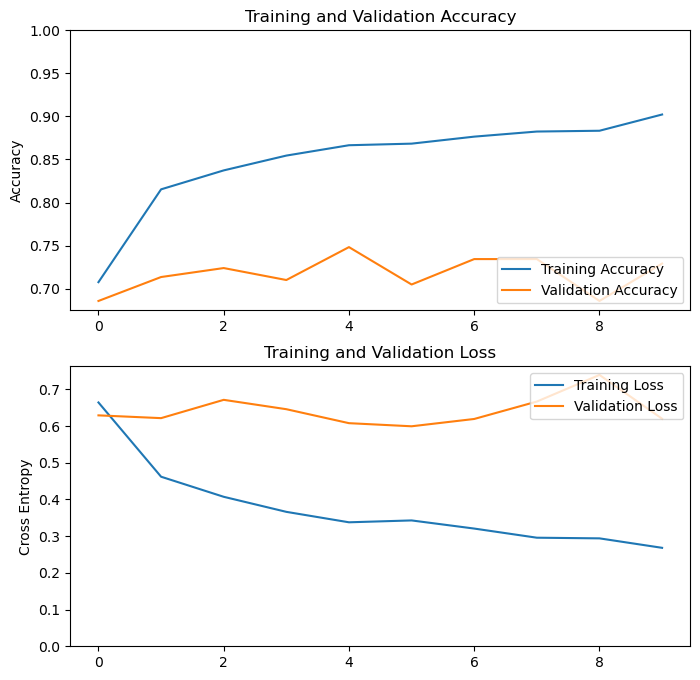

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

19/19 [==============================] - 75s 4s/step - loss: 0.6371 - accuracy: 0.7297
test accuracy :  0.7296848893165588


In [2]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model(r"C:\Users\lokes\Downloads\Documents\models\xception\model_05-0.75.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(256, 256))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    #plt.title("Loaded Image")
    #plt.axis('off')
    #plt.imshow(img.squeeze())
    #plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis])

    # Label array
    labels = {0: 'Mild', 1: 'Normal', 2:'Severe'}

    #print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = np.argmax(p[0], axis=-1)
    #print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    #print("\n-------------------Individual Probability--------------------------------\n")

    #for i,j in enumerate (p[0],0):
        #print(labels[i].upper(),':',round(j*100,2),'%')
        #classes.append(labels[i])
        #prob.append(round(j*100,2))
        
    return predicted_class

In [3]:
import os
from tqdm import tqdm

In [4]:
true_classes = []
predicted_classes = []
test_dir = r"C:\Users\lokes\Downloads\Documents\models\test"
class_names = ['mild', 'normal', 'severe']

for class_name in tqdm(class_names):
    class_dir = os.path.join(test_dir, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        predicted_class = predict(img_path)
        true_classes.append(class_names.index(class_name))
        predicted_classes.append(predicted_class)


true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 223ms/step


 33%|████████████████████████████                                                        | 1/3 [01:00<02:01, 60.96s/it]

1/1 [==============================] - 0s 205ms/step


 67%|████████████████████████████████████████████████████████                            | 2/3 [02:09<01:05, 65.66s/it]

1/1 [==============================] - 0s 211ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:25<00:00, 68.50s/it]


In [5]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [6]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
accuracy_score(true_classes,predicted_classes)

0.8919753086419753

In [9]:
confusion_matrix(true_classes,predicted_classes)

array([[177,   5,   8],
       [  6, 217,   7],
       [ 38,   6, 184]], dtype=int64)

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [11]:
f1_score(true_classes,predicted_classes,average = None)

array([0.86131387, 0.94759825, 0.8618267 ])

In [12]:
precision_score(true_classes,predicted_classes,average = None)

array([0.80090498, 0.95175439, 0.92462312])

In [13]:
recall_score(true_classes,predicted_classes,average = None)

array([0.93157895, 0.94347826, 0.80701754])

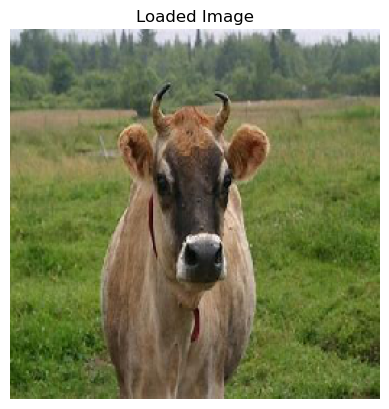

1/1 [==============================] - 2s 2s/step


Maximum Probability:  0.8071756
Classified: Normal 



-------------------Individual Probability--------------------------------

MILD : 15.85 %
NORMAL : 80.72 %
SEVERE : 3.43 %


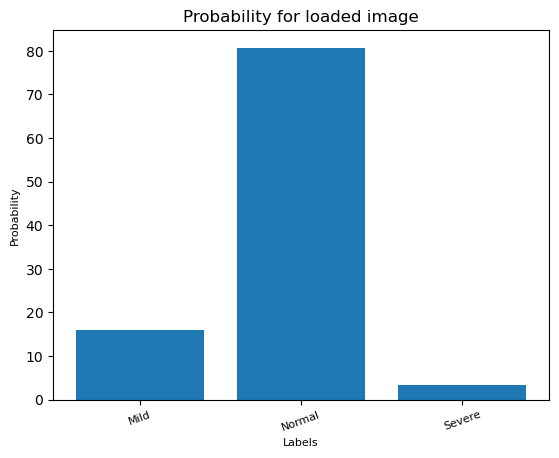

In [15]:
predict("C:/Users/lokes/Downloads/Documents/xception/1.jpg")

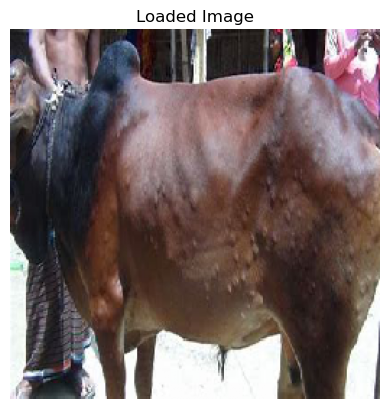

1/1 [==============================] - 0s 200ms/step


Maximum Probability:  0.8630178
Classified: Mild 



-------------------Individual Probability--------------------------------

MILD : 86.3 %
NORMAL : 9.76 %
SEVERE : 3.93 %


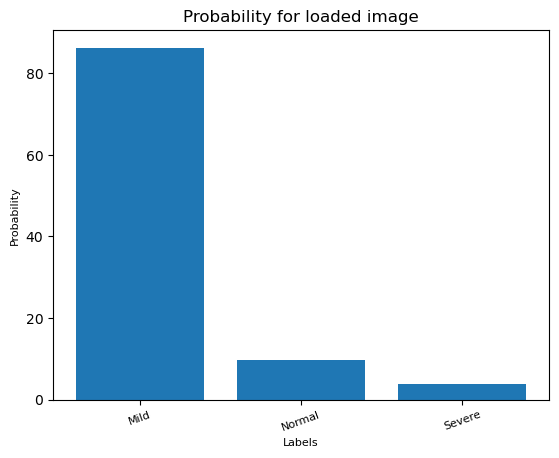

In [16]:
predict("C:/Users/lokes/Downloads/Documents/xception/2.jpg")

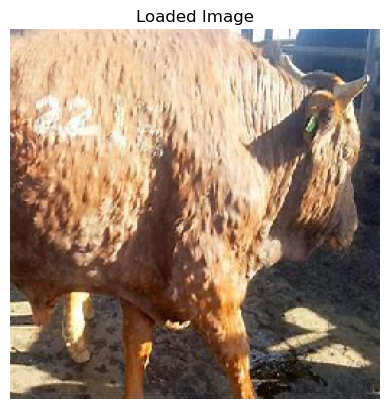

1/1 [==============================] - 0s 177ms/step


Maximum Probability:  0.8388879
Classified: Severe 



-------------------Individual Probability--------------------------------

MILD : 13.95 %
NORMAL : 2.16 %
SEVERE : 83.89 %


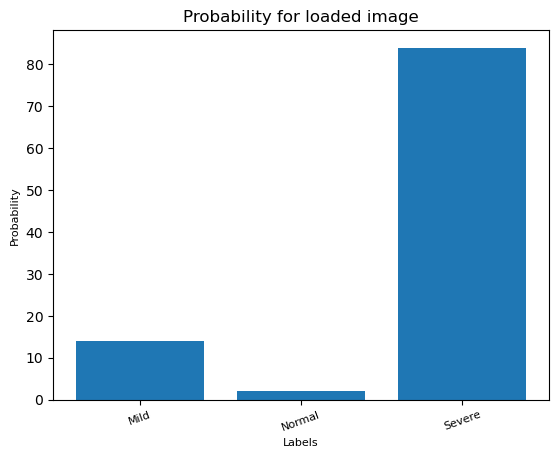

In [17]:
predict("C:/Users/lokes/Downloads/Documents/xception/3.jpg")

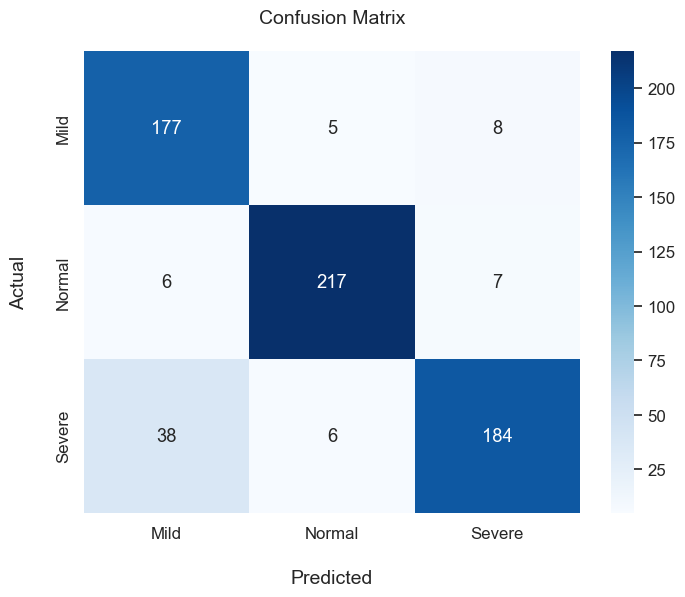

In [14]:
import seaborn as sns

plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)

cf_matrix = confusion_matrix(true_classes,predicted_classes)

ax = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap = 'Blues')

ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Mild', 'Normal','Severe'])

ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Mild', 'Normal','Severe'])

ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()